# 1D kernel basics

This example will cover:

 - Initialising the GPvecchia class with a kernel and some 1D data
 - Sampling from the prior
 - Making a prediction at new points
 - Sampling from the conditional distribution

In [1]:
from gpvecchia.vecchia import GPtideVecchia
import numpy as np
import matplotlib.pyplot as plt

We use an exponential-quadratic  kernel with a length scale $\ell$ = 100 and variance $\eta$ = $1.5^2$. The noise ($\sigma$) is 0.5. The total length of the domain is 2500 and we sample 100 data points.

`GPvecchia` only accepts covariance functions that use a distance matrix. 

In [2]:
from numba import njit

@njit(cache=True)
def expquad_1d(x, xpr, params):
    eta, l = params
    d = np.sum((x-xpr)**2)
    return eta**2. * np.exp(-d/(2*l*l))

In [3]:
####
# These are our kernel input parameters
noise = 0.5
η = 2
ℓ = 100
covfunc = expquad_1d

###
# Domain size parameters
dx = 25.
N = 1000
covparams = (η, ℓ)

# Input data points
xd = np.arange(0,dx*N,dx)[:,None]

# A re-ordering function should always be specified - the default is no re-ordering
order_func = np.random.permutation
order_params = len(xd)
ordering_index = order_func(order_params) # we don't need to do this, unless we compute neighbours outside the object

## Initialise the GPtide object and sample from the prior

Always specify a re-ordering function. Other optional args can be left as default.


(0.0, 5000.0)

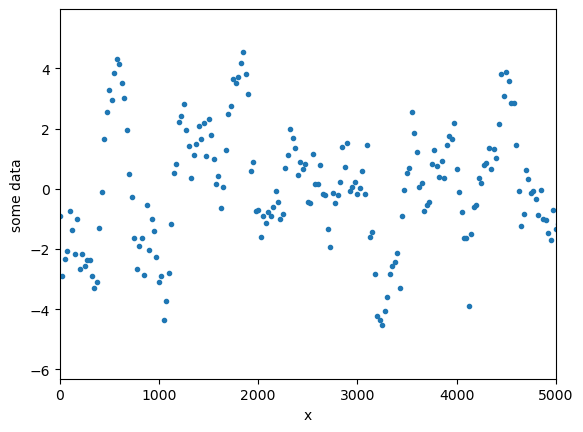

In [4]:
GP = GPtideVecchia(xd, xd, noise, covfunc, covparams, order_func=order_func, order_params=order_params)

# # Use the .prior() method to obtain some samples
# yd = GP.sample_prior(samples=1)

# Note the default is to not add noise
yd_noisy = GP.sample_prior(samples=1, add_noise=True)

plt.figure()
plt.plot(xd, yd_noisy, '.')
plt.ylabel('some data')
plt.xlabel('x')
plt.xlim(0, 5000)

## Search for nearest neighbours 

Example of how to search for neighbours outside of GP object (this is done automatically if neighbours are not supplied).

The neighbour search algorithm is limited to points that are lower than ix, so the nearest nnum points will not always exactly equal the true nearest points. 

(1000, 31)


(5975.0, 10975.0)

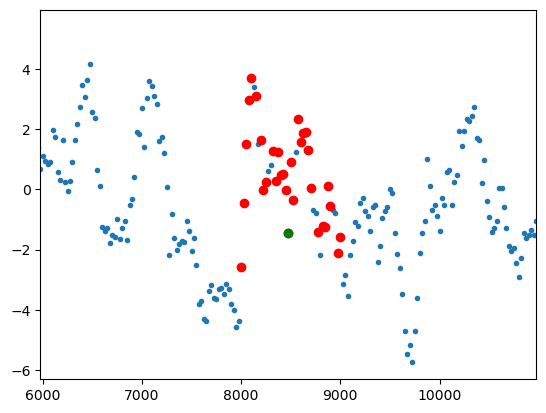

In [5]:
from gpvecchia.vecchia_utils import find_nn

num_neigh = 30
xd_reord = xd[ordering_index] # re-ordering essential for Vecchia
yd_reord = yd_noisy[ordering_index]

nn_array = find_nn(xd_reord, num_neigh)
print(nn_array.shape)

ix = 800
plt.plot(xd_reord, yd_reord, '.')
plt.plot(xd_reord[nn_array[ix]], yd_reord[nn_array[ix]], 'ro')
plt.plot(xd_reord[ix], yd_reord[ix], 'go')
plt.xlim(xd_reord[ix]-100*dx, xd_reord[ix]+100*dx)

Adding 6 random neighbours
(1000, 31)


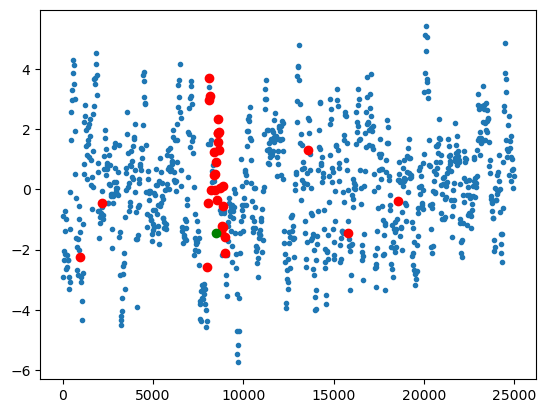

In [6]:
nn_array_r = find_nn(xd_reord, num_neigh, rand=20)
print(nn_array.shape)

ix = 800
plt.plot(xd_reord, yd_reord, '.')
plt.plot(xd_reord[nn_array_r[ix]], yd_reord[nn_array_r[ix]], 'ro')
plt.plot(xd_reord[ix], yd_reord[ix], 'go')
# plt.xlim(xd_reord[ix]-100*dx, xd_reord[ix]+100*dx)

In [13]:
nn_array.shape

(1000, 31)

In [12]:
nn_array[-5:]

array([[995, 963, 957, 950, 928, 781, 700, 676, 641, 614, 602, 588, 554,
        538, 516, 396, 371, 334, 310, 288, 241, 201, 187, 164,  89,  82,
         76,  74,  65,  54,  42],
       [996, 975, 863, 788, 763, 750, 733, 713, 702, 686, 683, 673, 636,
        551, 532, 488, 453, 398, 304, 267, 234, 231, 210, 202, 193, 132,
        121,  97,  83,  66,  35],
       [997, 973, 971, 958, 940, 860, 832, 726, 656, 604, 598, 597, 575,
        573, 549, 486, 474, 472, 383, 316, 233, 207, 155, 153, 151, 126,
         77,  17,  16,  14,  13],
       [998, 961, 869, 868, 854, 804, 766, 679, 649, 605, 580, 559, 544,
        501, 485, 466, 431, 382, 337, 331, 299, 239, 221, 214, 159, 108,
         71,  69,  30,  11,   2],
       [999, 989, 945, 942, 920, 905, 886, 813, 786, 777, 771, 739, 678,
        664, 651, 618, 576, 564, 528, 481, 412, 402, 339, 318, 305, 262,
        213, 156, 114, 112,  12]])

In [14]:
nn_array_r[-10:-5]

array([[990, 978, 910, 877, 857, 811, 808, 800, 734, 668, 659, 612, 593,
        558, 520, 503, 502, 441, 430, 416, 406, 404, 350, 196, 174, 123,
         98,  90,  58,  31,   6],
       [991, 986, 953, 912, 775, 756, 727, 708, 660, 642, 611, 540, 514,
        507, 500, 395, 343, 295, 289, 249, 246, 194, 189, 174, 167, 103,
         92,  86,  72,  67,  24],
       [946, 876, 834, 806, 754, 754, 752, 731, 705, 643, 639, 624, 622,
        619, 581, 526, 467, 342, 336, 335, 217, 211, 181, 154, 146, 144,
        133,  39,  28,  25,   3],
       [993, 958, 951, 933, 887, 785, 761, 748, 744, 658, 656, 633, 628,
        580, 573, 555, 522, 450, 365, 351, 285, 264, 257, 200, 175, 169,
        168, 165, 155, 130,  13],
       [994, 979, 966, 965, 948, 941, 921, 913, 849, 847, 819, 809, 793,
        780, 773, 759, 751, 732, 703, 681, 613, 558, 557, 519, 424, 259,
        210, 171, 166, 102,  53]])

## Make a prediction at new points using noisy data


In [7]:
nn_kwargs = {'rand': 20}

(-250.0, 4845.919183836768)

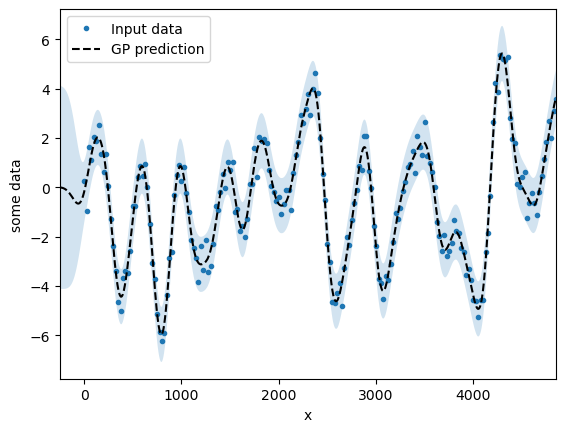

In [ ]:
# Output data points 
xo = np.linspace(-10*dx, dx*N+dx*10, N*5)[:,None]

# Create a new object with the output points
GP2 = GPtideVecchia(xd, xo, noise, covfunc, covparams,
                    order_func=order_func, order_params=order_params,
                    nn_kwargs=nn_kwargs)

# Predict the mean + var
y_mu, y_std = GP2(yd_noisy)

plt_ix = np.arange(0,1000)
plt.figure()
plt.plot(xd, yd_noisy,'.')
plt.plot(xo[plt_ix], y_mu[plt_ix],'k--')
plt.fill_between(xo.flatten()[plt_ix],
                 (y_mu.flatten()-2*y_std.flatten())[plt_ix],
                 (y_mu.flatten()+2*y_std.flatten())[plt_ix],
                 alpha=0.2)
plt.legend(('Input data','GP prediction'))
plt.ylabel('some data')
plt.xlabel('x')
plt.xlim([xo[plt_ix[0]],xo[plt_ix[-1]]])

## Make a prediction of the full conditional distribution at new points

In [9]:
def forward_solve(L, b):
    n = L.shape[0]
    m = b.shape[1] if b.ndim > 1 else 1  # Handle both vector and matrix cases
    x = np.zeros((n, m))

    for k in range(m):  # Solve for each column of b
        for i in range(n):
            sumj = 0.0
            for j in range(i):
                sumj += L[i, j] * x[j, k]
            x[i, k] = (b[i, k] if m > 1 else b[i]) - sumj
            x[i, k] /= L[i, i]

    return x

In [10]:
from gpvecchia.vecchia_utils import forward_solve, get_pred_nn
from gpvecchia.vecchia import K_matrix

nn_array = get_pred_nn(xo, xd_reord, num_neigh)
no_array = get_pred_nn(xo, xo, num_neigh)
print(no_array.shape)
print(no_array)

(5000, 30)
[[   0    1    2 ...   27   28   29]
 [   1    2    0 ...   27   28   29]
 [   2    1    3 ...   27   28   29]
 ...
 [4997 4998 4996 ... 4972 4971 4970]
 [4998 4997 4999 ... 4972 4971 4970]
 [4999 4998 4997 ... 4972 4971 4970]]


In [11]:
# @njit(cache=True, parallel=True)
# def sample_posterior(xd, xm, NNarray_input, NNarray_output, yd, cov_func, cov_params, noise):

n_pred = xo.shape[0]
post_samp = np.zeros(n_pred)

for i in range(n_pred):
    # Get the indices of the nearest neighbors
    idx_input = nn_array[i]
    idx_input = idx_input[idx_input >= 0]
    
    idx_output = no_array[i]
    idx_output = idx_output[idx_output >= 0]

    # Get the training and prediction points
    Xp = xd_reord[idx_input, :]
    Xo = xo[idx_output, :]

    # Compute the covariance matrices
    Koo = K_matrix(Xo, Xo, covfunc, covparams, noise)  # Covariance of output neighbors
    Kpp = K_matrix(Xp, Xp, covfunc, covparams, noise)  # Covariance of the prediction point
    Kop = K_matrix(Xo, Xp, covfunc, covparams, noise)  # Cross-covariance between output and prediction

    # Cholesky decomposition of Koo
    Loo = np.linalg.cholesky(Koo)

    # Solve for the conditional mean and variance
    alpha = forward_solve(Loo, yd_noisy[idx_input])
    pred_mean = Kop.T @ alpha
    v = forward_solve(Loo, Kop)
    pred_var = Kpp - v.T @ v

    # Draw a sample from the posterior
    post_samp[i] = np.random.normal(pred_mean[0], np.sqrt(pred_var[0, 0]))

    # return samples

ValueError: cannot assign slice from input of different size

In [13]:
np.random.normal(pred_mean, np.sqrt(pred_var)).shape

/tmp/ipykernel_2410521/3753408115.py:1: RuntimeWarning: invalid value encountered in sqrt
  np.random.normal(pred_mean, np.sqrt(pred_var)).shape


(30, 30)

In [16]:
post_samp[i]

0.0

(-250.0, 4845.919183836768)

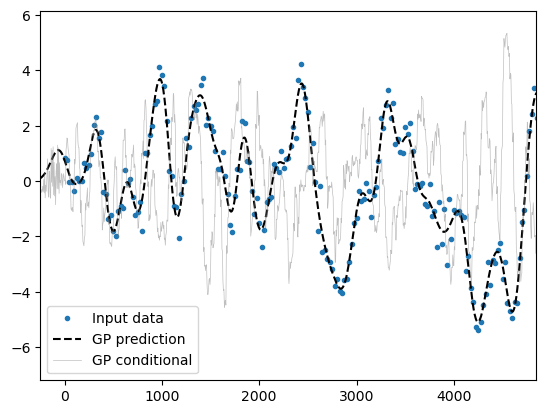

In [19]:
samples = 1
# y_conditional = GP2.conditional(yd_noisy, samples=samples)

plt_ix = np.arange(0,1000)
plt.figure()
plt.plot(xd, yd_noisy,'.')
plt.plot(xo, y_mu,'k--')

for ii in range(samples):
    plt.plot(xo, post_samp/20, '0.5', lw=0.5, alpha=0.5)
    
plt.legend(('Input data','GP prediction','GP conditional'))
plt.xlim([xo[plt_ix[0]],xo[plt_ix[-1]]])

You can see that in the current implementation of Vecchia the estimates at prediction points do not consider other prediction points, only the input points. This makes draws from the conditional distribution ***incorrect***, as each point is independent of other points in the posterior sample. You can see the draw is overly noisy both around input data and more so away from input data. 
